In [157]:
#Importing Libraries

#for pulling and formating data
import requests
import pandas as pd
import json

#for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.ticker import PercentFormatter

#For textual analysis
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt')

pd.options.mode.chained_assignment = None




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lpuga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lpuga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Understand data and pull out product options

In [158]:
#Pull small sample
headers = {
    'accept': 'application/json',
}

params = (
    ('company_received_min', '2016-01-01'),
    ('company_received_max', '2016-12-31'),
    ('format', 'json'),
    ('state', 'NY'),
)

response = requests.get('https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/', headers=headers, params=params)


#Checking that request worked
print("Checking that data was pulled correctly.", '\n')
response.raise_for_status()
print('Pulling info', '\n', '\n')

#formating response as json
sample_data = response.json()
#De-nesting data
sample_data = pd.json_normalize(sample_data)

#List variable names in dataset
print('\033[1m'+'Variable Names'+'\033[0m', *list(sample_data.columns),sep='\n')
print('\n')

#Find products in databases
print('\033[1m'+ 'Products' + '\033[0m', *sample_data["_source.product"].unique(), sep='\n')



Checking that data was pulled correctly. 

Pulling info 
 

Variable Names
_index
_type
_id
_score
sort
_source.product
_source.complaint_what_happened
_source.date_sent_to_company
_source.issue
_source.sub_product
_source.zip_code
_source.tags
_source.complaint_id
_source.timely
_source.consumer_consent_provided
_source.company_response
_source.submitted_via
_source.company
_source.date_received
_source.state
_source.consumer_disputed
_source.company_public_response
_source.sub_issue


Products
Credit reporting
Bank account or service
Student loan
Mortgage
Debt collection
Credit card
Money transfers
Payday loan
Consumer Loan
Prepaid card
Other financial service


# Subset relevant data for analysis

In [159]:
#Adjust parameters to pull another subset focused on a specific product 
headers = {
    'accept': 'application/json',
}

params = (
    ('company_received_min', '2012-01-01'),
    ('company_received_max', '2020-01-01'),
    ('product', 'Student loan'),
    ('state','CA'),
    ('format', 'json')
)

response = requests.get('https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/', 
                        headers=headers, params=params)


#Checking that request worked
print("Checking that data was pulled correctly.", '\n')
response.raise_for_status()
print('Pulling info...', '\n', '\n')

#formating response as json
data = response.json()
#De-nesting data
data = pd.json_normalize(data)
#show formatted data as pandas dataframes
print('Done!')
print('\033[1m'+ 'Data preview' + '\033[0m')
data

Checking that data was pulled correctly. 

Pulling info... 
 

Done!
Data preview


,_index,_type,_id,_score,sort,_source.product,_source.complaint_what_happened,_source.date_sent_to_company,_source.issue,_source.sub_product,...,_source.timely,_source.consumer_consent_provided,_source.company_response,_source.submitted_via,_source.company,_source.date_received,_source.state,_source.consumer_disputed,_source.company_public_response,_source.sub_issue
0,complaint-public-v1,_doc,3230134,None,[7],Student loan,,2019-05-02T12:00:00-05:00,Incorrect information on your report,Federal student loan servicing,...,Yes,Consent not provided,Closed with explanation,Web,"Nelnet, Inc.",2019-05-02T12:00:00-05:00,CA,N/A,None,Account status incorrect
1,complaint-public-v1,_doc,3137623,None,[56],Student loan,"XXXX College is known as a scammer school that shut its doors on its students and left everyone in debt. \n\nI transferred out of XXXX College a year before it closed down due to the fact that I didnt believe they had given me the education they promised, they didnt train me properly, and they promised I would be finished in 2 years, which I absolutely wasnt. Nor was any of my peers. \n\nA yea...",2019-01-30T12:00:00-05:00,Struggling to repay your loan,Private student loan,...,Yes,Consent provided,Closed with explanation,Web,AES/PHEAA,2019-01-30T12:00:00-05:00,CA,N/A,None,Can't get other flexible options for repaying your loan
2,complaint-public-v1,_doc,3124122,None,[92],Student loan,,2019-01-14T12:00:00-05:00,Getting a loan,Private student loan,...,Yes,Consent not provided,Closed with explanation,Web,"EQUIFAX, INC.",2019-01-14T12:00:00-05:00,CA,N/A,None,Fraudulent loan
3,complaint-public-v1,_doc,3244001,None,[128],Student loan,"I had already made my payment for this month and had a {$0.00} balance due. I got an email today from Navient, XX/XX/19, that "" the payment term for your loans has changed ''. It then says next payment amount : {$50.00}, and next payment due date : XX/XX/19. So they changed the terms of my loan to instantly cause a past due payment. I go into my loan and sure enough, it has in big red letters ...",2019-05-16T12:00:00-05:00,Dealing with your lender or servicer,Federal student loan servicing,...,Yes,Consent provided,Closed with explanation,Web,"Navient Solutions, LLC.",2019-05-16T12:00:00-05:00,CA,N/A,None,Trouble with how payments are being handled
4,complaint-public-v1,_doc,3196065,None,[161],Student loan,,2019-03-30T12:00:00-05:00,Dealing with your lender or servicer,Private student loan,...,Yes,Consent not provided,Closed with explanation,Web,"Navient Solutions, LLC.",2019-03-29T12:00:00-05:00,CA,N/A,None,Received bad information about your loan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5805,complaint-public-v1,_doc,2562384,None,[465005],Student loan,,2017-06-29T12:00:00-05:00,Getting a loan,Private student loan,...,Yes,Consent not provided,Closed with explanation,Web,"Navient Solutions, LLC.",2017-06-29T12:00:00-05:00,CA,N/A,None,Confusing or misleading advertising
5806,complaint-public-v1,_doc,72583,None,[465443],Student loan,,2012-05-09T12:00:00-05:00,Repaying your loan,Non-federal student loan,...,Yes,N/A,Closed with monetary relief,Web,"Navient Solutions, LLC.",2012-05-07T12:00:00-05:00,CA,No,None,None
5807,complaint-public-v1,_doc,1637332,None,[465592],Student loan,"In XX/XX/XXXX, I took out a few private loans which to help cover the high cost of living in XXXX XXXX, where my school, the XXXX XXXX XXXX XXXX is located ( I earned a XXXX ). These loans were eventually consolidated ( without my consent ) into XXXX large loan which has since been purchased by ACS ( original lender was XXXX XXXX XXXX ). The lender has changed several times during this process...",2015-11-03T12:00:00-05:00,Can't repay my loan,Non-federal student loan,...,Yes,Consent provided,Closed with explanation,Web,ACS Education Services,2015-11-03T12:00:00-05:00,CA,No,None,Can't decrease my monthly payments
5808,complaint-public-v1,_doc,191825,None,[465953],Student loan,,2012-11-1

# Explore cross-sectional and time-series variation

Summary Stats by Company
count    172.00
mean      33.78
std      211.49
min        1.00
25%        1.00
50%        3.00
75%        8.00
max     2615.00
Name: _source.company, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


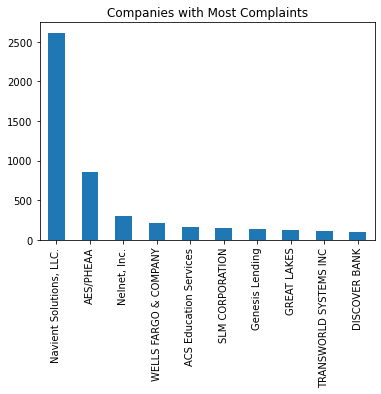

In [160]:
#Summarize frequency of companies
print('\033[1m' + 'Summary Stats by Company' + '\033[0m')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(data["_source.company"].value_counts().describe())

#Graphing top 10 companies 
print(data["_source.company"].value_counts().head(10).plot(kind="bar", title="Companies with Most Complaints"))


Ranked complaints by issues
Dealing with my lender or servicer                                                  1946
Dealing with your lender or servicer                                                1605
Can't repay my loan                                                                  851
Struggling to repay your loan                                                        562
Repaying your loan                                                                   345
Problems when you are unable to pay                                                  165
Getting a loan                                                                       138
Incorrect information on your report                                                 134
Problem with a credit reporting company's investigation into an existing problem      47
Credit monitoring or identity theft protection services                               10
Improper use of your report                                                       

<AxesSubplot:title={'center':'By Issue'}>

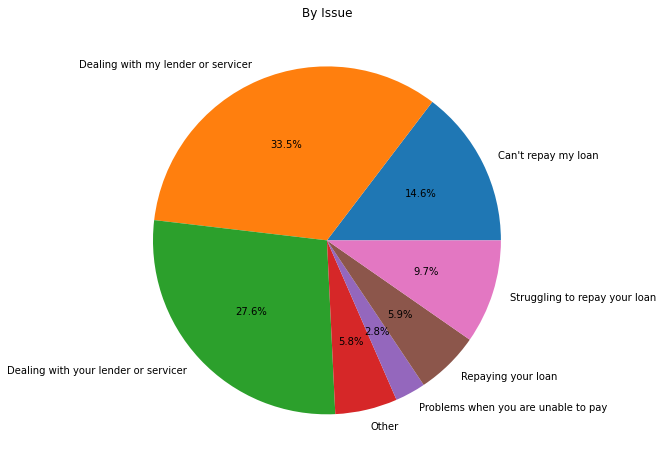

In [161]:
#Summarize types of issues
print('\033[1m' + 'Ranked complaints by issues' +'\033[0m')
print(data["_source.issue"].value_counts())

#Printing pie chart
pie=data['_source.issue'].value_counts()
value = (len(data)*.025)
pie.groupby(np.where(pie>=value,pie.index,'Other')).sum().plot.pie( title="By Issue", figsize=(8,8), ylabel='', 
                                                                autopct='%1.1f%%')




AxesSubplot(0.125,0.125;0.775x0.755)


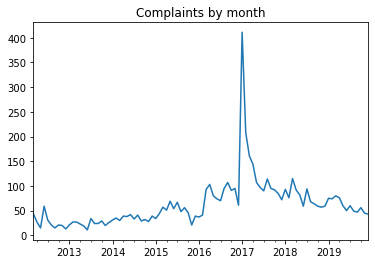

In [162]:
#Summarize time series of complaints

#Ensure date is in date format 
data["_source.date_sent_to_company"] = pd.to_datetime(data["_source.date_sent_to_company"]).dt.date
data['month'] = pd.to_datetime(data['_source.date_sent_to_company']).dt.to_period('M')
frequency = data['month'].value_counts()

#Plotting complaints by date 
print(frequency.sort_index().plot(title="Complaints by month"))

By Percentages 
 Yes   98.40
No     1.60
Name: _source.timely, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


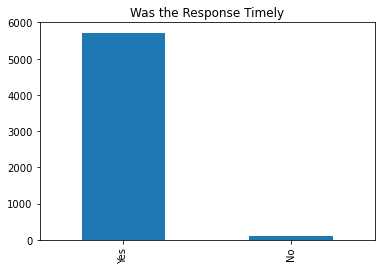

In [163]:
#Checking if response was timely 
print('\033[1m'+ 'By Percentages' + '\033[0m', '\n', data["_source.timely"].value_counts(normalize=True)*100)

print(data["_source.timely"].value_counts().plot(kind="bar", title="Was the Response Timely"))

# Looking at the Text of the Complaints

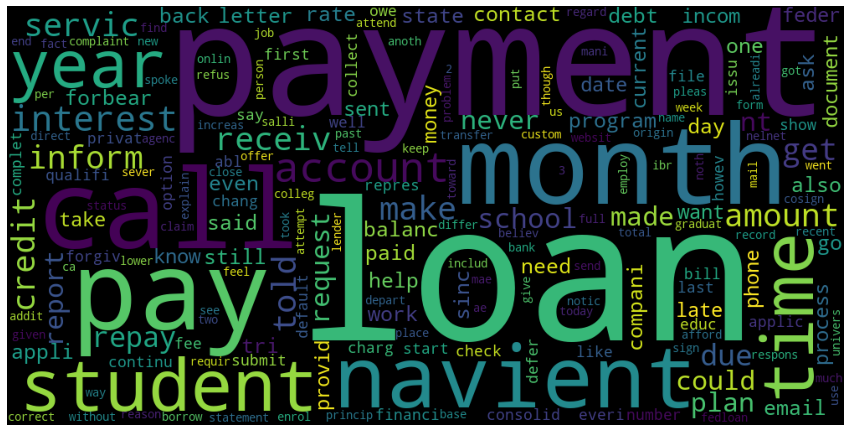

In [165]:
# Use English stemmer.
stemmer = SnowballStemmer("english")

#Removing Stopwords
extra_stops=["xxxx","xxxxxxxx","would"]
stoplist = stopwords.words('english') + extra_stops

narrative = data['_source.complaint_what_happened']

#Lowercase
narrative = narrative.apply(lambda x: " ".join(x.lower() for x in x.split()))
#Remove punct.
narrative = narrative.str.replace('[^\w\s]','',regex=True)
#Remove stopwords
narrative= narrative.apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))
#Tokenize words
narrative = narrative.apply(word_tokenize)
#Stemming words
narrative = narrative.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.

#Get frequencies
results=Counter()
narrative.apply(results.update)

#Creating wordcloud
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(results)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [166]:
narrative_bigrams = narrative.apply(lambda row: list(nltk.ngrams(row, 2)))
results_bigram = Counter()
narrative_bigrams.apply(results_bigram.update)

print('\033[1m'+ '20 Most Common Bigrams' + '\033[0m', *results_bigram.most_common(20), sep='\n')


20 Most Common Bigrams
(('student', 'loan'), 2164)
(('make', 'payment'), 642)
(('month', 'payment'), 631)
(('interest', 'rate'), 594)
(('credit', 'report'), 493)
(('loan', 'servic'), 449)
(('repay', 'plan'), 436)
(('pay', 'loan'), 425)
(('loan', 'forgiv'), 419)
(('privat', 'loan'), 349)
(('salli', 'mae'), 333)
(('custom', 'servic'), 314)
(('loan', 'payment'), 288)
(('even', 'though'), 265)
(('payment', 'made'), 262)
(('past', 'due'), 244)
(('servic', 'loan'), 244)
(('payment', 'plan'), 244)
(('late', 'fee'), 241)
(('public', 'servic'), 232)


# Sentiment Analysis

In [167]:
# function to calculate polarity
def getPolarity(review):
     return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

data['Polarity'] = data['_source.complaint_what_happened'].apply(getPolarity) 
data['Pos/Neg?'] = data['Polarity'].apply(analysis)

data_with_narrative = data[data['_source.complaint_what_happened'] != '']

print('\033[1m'+ 'By Percentages' + '\033[0m', '\n', data_with_narrative["Pos/Neg?"].value_counts(normalize=True)*100)

pd.set_option('max_colwidth', 400)

data_with_narrative[["_source.complaint_what_happened", 'Polarity','Pos/Neg?']].sort_values("Polarity")

By Percentages 
 Positive   55.70
Negative   38.16
Neutral     6.13
Name: Pos/Neg?, dtype: float64
Printing out values with neutral polarity


,_source.complaint_what_happened,Polarity,Pos/Neg?
3206,"My student loan got transferred to another student loan company called ECSI. ECSI charges a "" convenience fee '' of {$.00} everytime I make a payment using my checking account. That is absolutely outrageous. Why do they make a dollar for me to pay using my checking account?",-1.00,Negative
2030,I am being harassed by XXXX ( XXXX XXXX XXXX XXXX XXXX ). I have told them that I am dealing with the forbearance request and to stop calling me. They call me on my cell phone 3-4 times per day after I told them to stop. Sometimes when I answer the call they just hang up on me. I am very frustrated with this distraction in my life and wish they would stop harassing me. Please help.,-0.91,Negative
3793,"Naviet changed rates, loan types, & interest rates without notification. The payment suggested to me is impossible to pay. Naviet suggested that I defer them which increased the interest amount on a monthly basis",-0.67,Negative
3239,"I continuously try and pay my student loans with Navient.com, but everytime I go online or call to pay my loans it says my balance is {$0.00}. I know I owe at least {$48000.00} approximately. I am getting very frustrated trying to pay when I am unable to.",-0.53,Negative
464,I received a XXXX for XX/XX/2017 reporting the wrong amount of interest : {$1300.00}. The actual interest I paid was : {$4700.00}. I tried to resolve this discrepancy with XXXX XXXX since XX/XX/2017.,-0.50,Negative
...,...,...,...
1397,Timemark solutions contacted me repeatedly and aggressively. They claimed they worked for the federal government and told me that I would have to pay fees to enter loan consolidation and income based repayment. They charged me 3 fees of XXXX and did not file the appropriate paperwork to enter into loan consolidation. They refused to offer any assistance after the fees were paid. Their agents a...,0.50,Positive
4861,"When I started to lookup how to consolidate my loans, I did not know what I was doing, I did not know what plan was best for me nor did I understand the terms. FedLoan Servicing told me what to fill out and that they would "" select the best plan for me '' and of course as it turns out it was not the best nor was the payment affordable. I am now stuck in the plan because they refuse to switch m...",0.54,Positive
3689,When I took a XXXX mortgage on my house the loaner insisted we pay the loan in full and we did. Great Lakes XXXX.mygreatlakes.org XXXX is charging us interest from after the loan was paid off. They wo n't stop calling and emailing. This is harassment. I have sent them a copy of the check 3 times and they wo n't stop.,0.57,Positive
3886,"Bank checks issued payable to Department of Education to fully pay off my parent loans with Great Lakes. \n\nXX/XX/XXXX- U.S . Postal Tracking confirmation that the checks were received by the Department Of Education ( XXXX.XXXX XXXX, XXXX, GA XXXX ). \nXXXX Both checks were cashed on this date. \n\nTO THIS DATEXX/XX/XXXX my account has not been updated with the payoff payments I have made. \n...",0.66,Positive


count   2788.00
mean       0.01
std        0.13
min       -1.00
25%       -0.04
50%        0.02
75%        0.08
max        0.80
Name: Polarity, dtype: float64


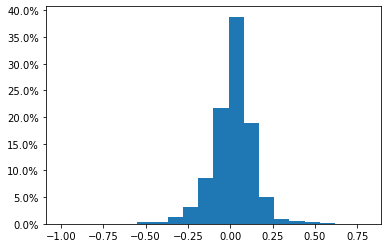

In [168]:
plt.hist(data_with_narrative["Polarity"], 
         weights=np.ones(len(data_with_narrative["Polarity"])) / len(data_with_narrative["Polarity"]),
         bins=20)


plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

print(data_with_narrative["Polarity"].describe())


# Comparing with other datasets

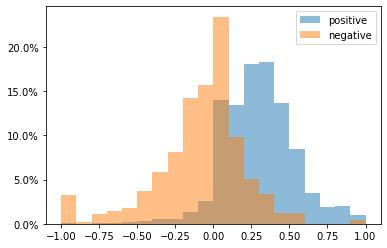

In [169]:
#hotels dataset from https://data.world/datafiniti/hotel-reviews

hotel_reviews = pd.read_csv('hotel_reviews-sub.csv')

#Subset into 2 datasets; one positive, one negative hotel reviews
hotel_reviews_pos = hotel_reviews[hotel_reviews['reviews.rating'] == (4 or 5)]
hotel_reviews_pos["reviews.text"] = hotel_reviews_pos["reviews.text"].apply(lambda x: str(x))
hotel_reviews_neg = hotel_reviews[hotel_reviews['reviews.rating'] == (1 or 2)]
hotel_reviews_neg["reviews.text"] = hotel_reviews_neg["reviews.text"].apply(lambda x: str(x))

#Create variables Polarity and Neg/Pos?
hotel_reviews_pos['Polarity'] = hotel_reviews_pos["reviews.text"].apply(getPolarity) 
hotel_reviews_pos['Neg/Pos?'] = hotel_reviews_pos['Polarity'].apply(analysis)
hotel_reviews_neg['Polarity'] = hotel_reviews_neg["reviews.text"].apply(getPolarity) 
hotel_reviews_neg['Neg/Pos?'] = hotel_reviews_neg['Polarity'].apply(analysis)

#Plot + and - hotel reviews in overlayed histograms
plt.hist(hotel_reviews_pos["Polarity"], weights=np.ones(len(hotel_reviews_pos["Polarity"])) / 
         len(hotel_reviews_pos["Polarity"]),
         bins=20, alpha=0.5)

plt.hist(hotel_reviews_neg["Polarity"], weights=np.ones(len(hotel_reviews_neg["Polarity"])) / 
         len(hotel_reviews_neg["Polarity"]),
         bins=20, alpha =0.5)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Add a legend
plt.legend(('positive', 'negative'), loc='upper right')



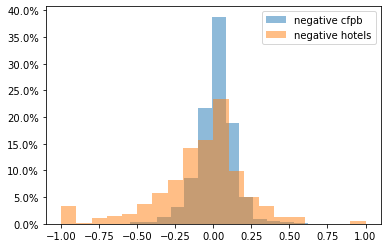

In [170]:
#Plot complaints and - hotel reviews in overlayed histograms
plt.hist(data_with_narrative["Polarity"], weights=np.ones(len(data_with_narrative["Polarity"])) / 
         len(data_with_narrative["Polarity"]),
         bins=20,alpha =0.5)
plt.hist(hotel_reviews_neg["Polarity"], weights=np.ones(len(hotel_reviews_neg["Polarity"])) / 
         len(hotel_reviews_neg["Polarity"]),
         bins=20, alpha =0.5)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))


plt.legend(('negative cfpb', 'negative hotels'), loc='upper right')

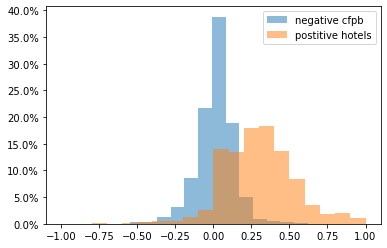

In [171]:
#Plot complains and + hotel reviews in overlayed histograms
plt.hist(data_with_narrative["Polarity"], weights=np.ones(len(data_with_narrative["Polarity"])) / 
         len(data_with_narrative["Polarity"]),
         bins=20,alpha =0.5)

plt.hist(hotel_reviews_pos["Polarity"], weights=np.ones(len(hotel_reviews_pos["Polarity"])) / 
         len(hotel_reviews_pos["Polarity"]),
         bins=20, alpha=0.5)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.legend(('negative cfpb', 'postitive hotels'), loc='upper right')